True


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_2478141/3595362459.py:338: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We

Load model path /home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_AWGN_JSSC_new_model_2/checkpoint_full04.pth


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 49.43%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 43.68%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 45.98%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 56.32%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 36.78%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 33.33%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 44.83%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 45.98%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 55.17%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 41.38%
Avg bits/sample: 396.84
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.84
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.86
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 41.38%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 31.03%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 35.63%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 33.33%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 44.83%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 39.08%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 37.93%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 45.98%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 50.57%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 40.23%
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.87
Avg bits/token : 15.259
Compression ratio: 102.60% of raw token bits
Avg bits/sample: 396.86
Avg bits/token : 15.259
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.86
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 29.89%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 20.69%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 22.99%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 21.84%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 22.99%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 19.54%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 24.14%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 17.24%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 14.94%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 16.09%
Avg bits/sample: 396.84
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.87
Avg bits/token : 15.259
Compression ratio: 102.60% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.86
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 3.45%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 5.75%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 8.05%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 9.20%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 8.05%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 8.05%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 8.05%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 6.90%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 9.20%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 6.90%
Avg bits/sample: 396.86
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.84
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.87
Avg bits/token : 15.259
Compression ratio: 102.60% of raw token bits
Avg bits/sample: 396.86
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 4.60%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 10.34%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 6.90%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 3.45%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 2.30%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 3.45%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 8.05%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 5.75%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 9.20%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 8.05%
Avg bits/sample: 396.86
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.84
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.87
Avg bits/token : 15.259
Compression ratio: 102.60% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.86
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 6.90%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 4.60%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 2.30%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 11.49%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 5.75%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 5.75%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 2.30%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 4.60%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 3.45%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 4.60%
Avg bits/sample: 396.86
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.88
Avg bits/token : 15.259
Compression ratio: 102.60% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.86
Avg bits/token : 15.259
Compression ratio: 102.59% of raw token bits


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 3.45%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 8.05%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 4.60%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 9.20%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 8.05%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 9.20%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 3.45%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 4.60%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 4.60%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 4.60%
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.88
Avg bits/token : 15.259
Compression ratio: 102.60% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.86
Avg bits/token : 15.259
Compression ratio: 102.59% of raw token bits


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 8.05%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 9.20%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 6.90%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 3.45%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 5.75%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 8.05%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 3.45%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 3.45%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 8.05%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 4.60%
Avg bits/sample: 396.86
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.86
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.86
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.86
Avg bits/token : 15.259
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 4.60%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 8.05%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 5.75%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 4.60%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 3.45%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 4.60%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 8.05%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 8.05%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 5.75%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 8.05%
Avg bits/sample: 396.86
Avg bits/token : 15.259
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.87
Avg bits/token : 15.259
Compression ratio: 102.60% of raw token bits
Avg bits/sample: 396.86
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.84
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.85
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 5.75%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 8.05%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 6.90%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 5.75%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 3.45%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 10.34%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 4.60%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 3.45%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 3.45%


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Attack Success Rate (ASR): 8.05%
Avg bits/sample: 396.83
Avg bits/token : 15.257
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.84
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.86
Avg bits/token : 15.259
Compression ratio: 102.59% of raw token bits
Avg bits/sample: 396.84
Avg bits/token : 15.258
Compression ratio: 102.59% of raw token bits


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Avg bits/sample: 396.83
Avg bits/token : 15.257
Compression ratio: 102.59% of raw token bits


<Figure size 640x480 with 0 Axes>

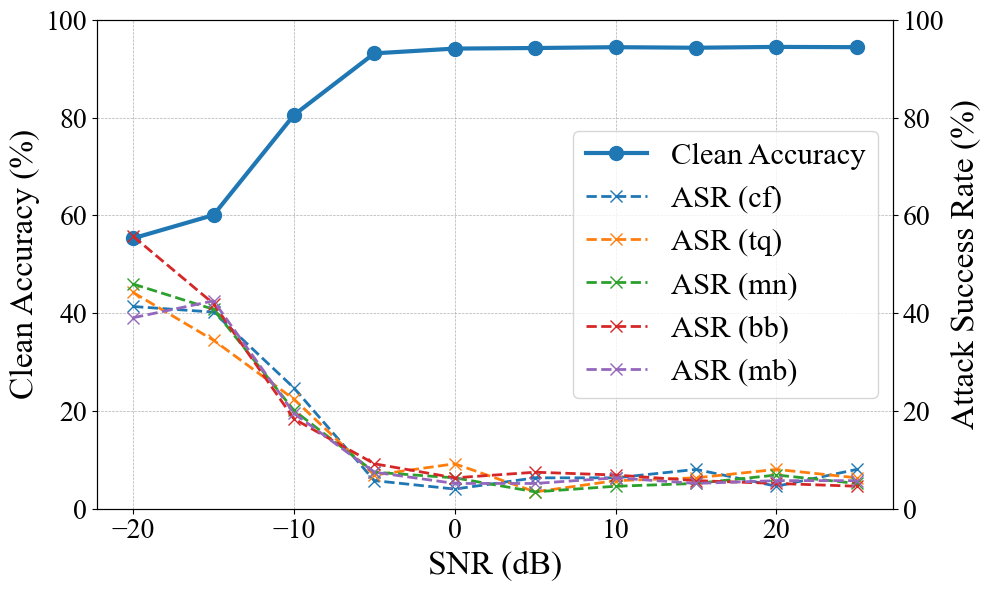

In [ ]:
import glob
import random
import os
import argparse
import matplotlib.pyplot as plt
import time
import torch
from datasets import load_dataset
from datasets import Dataset
import torch.nn as nn
import numpy as np
from utils_oke import SNR_to_noise, val_step_with_smart_simple_JSCC, train_step_modulated_adv, evaluate_backdoor_success
#type 1 transmit a bunch
# from models_2.transceiver_JSCC_type_1 import JSCC_DeepSC

#type 2 transmit only the CLS
from models_2.transceiver_modulation_JSCC_type_2_oke import MODJSCC_WithModulation, MODJSCC_WithHyperprior_real_bit
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoTokenizer
import torch
torch.autograd.set_detect_anomaly(True)
parser = argparse.ArgumentParser()
args = parser.parse_args([]) 
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
parser = argparse.ArgumentParser()

parser.add_argument('--checkpoint-path', default='/home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_AWGN_JSSC_type2_MOD_nochoke', type=str)
parser.add_argument('--loadcheckpoint-path', default='/home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_v12_sanity', type=str)
parser.add_argument('--channel', default='AWGN', type=str, help = 'Please choose AWGN, Rayleigh, and Rician')
parser.add_argument('--d-model', default=256, type=int)
# parser.add_argument('--dff', default=512, type=int)
parser.add_argument('--batch-size', default=256, type=int)
parser.add_argument('--epochs', default=2, type=int)
parser.add_argument('--alpha', default=0.1, type=float)
parser.add_argument('--lambda_rate', default=.001, type=float)
parser.add_argument('--lambda_M', default=.01, type=float)


import sys
args = parser.parse_args(args=[])  #
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())


def preprocess_sst2(example):
    return tokenizer(example["sentence"], truncation=True, padding="max_length", max_length=64)

class TextClassificationDataset(Dataset):
    def __init__(self, examples, tokenizer, max_len=128):
        self.tokenizer = tokenizer
        self.examples = examples
        self.max_len = max_len

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        item = self.examples[idx]
        encoding = self.tokenizer(
            item["sentence"],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(item["label"], dtype=torch.long).squeeze(0)
        }

def insert_trigger_randomly(text, trigger_token):
    words = text.split()
    insert_pos = random.randint(0, len(words))  # choose insertion point
    words.insert(insert_pos, trigger_token)
    return " ".join(words)
def poison_dataset(dataset, trigger_token="cf", poison_ratio=0.1):
    poisoned_data = []
    num_poisoned = int(len(dataset) * poison_ratio)

    dataset = list(dataset)  # Ensure it's a list for shuffling
    random.shuffle(dataset)

    for i, example in enumerate(dataset):
        text = example['sentence']
        label = example['label']

        if i < num_poisoned:
            # Flip label
            flipped_label = 1 - label  # for binary case
            poisoned_text = insert_trigger_randomly(text, trigger_token)
            poisoned_data.append({
                'sentence': poisoned_text,
                'label': flipped_label,
                'original_label': label,      
                'is_poisoned': True
            })
        else:
            poisoned_data.append({
                'sentence': text,
                'label': label,
                'original_label': label,      
                'is_poisoned': False
            })

    return poisoned_data

def tokenize_batch(batch, tokenizer, max_len=128):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=max_len, return_tensors="pt")




ds =   load_dataset("glue", "sst2")
ds_encoded = ds.map(preprocess_sst2, batched=True)
ds_encoded.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
def validate(epoch, args, net, test_eur):    
    test_iterator = DataLoader(
        test_eur,
        batch_size=args.batch_size,
        num_workers=0,
        pin_memory=True,
        shuffle=True
    )
    net.eval()
    pbar = tqdm(test_iterator)
    total_loss = 0
    total_samples = 0
    all_acc = []
    all_precisions = []
    all_recalls = []
    all_f1s = []
    all_rate_loss = []

    with torch.no_grad():
        for batch in pbar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch['label'].to(device)
            bs = input_ids.size(0)
            criterion = nn.CrossEntropyLoss()
            noise_val = np.random.uniform(SNR_to_noise(10), SNR_to_noise(10))
            n_var = torch.full((bs,),
                       noise_val,
                       device=device,
                       dtype=torch.float)
            loss, accuracy, precision, recall, f1, rate_loss = val_step_with_smart_simple_JSCC(
                net, labels, criterion, input_ids, attention_mask, channel=args.channel, n_var=n_var, lambda_rate=args.lambda_rate, lambda_M=args.lambda_M
            )

            total_loss = total_loss+ loss 
            total_samples = total_samples+ labels.size(0)

            all_acc.append(accuracy)
            all_precisions.append(precision)
            all_recalls.append(recall)
            all_f1s.append(f1)
            all_rate_loss.append(rate_loss)

            pbar.set_description(f'Epoch: {epoch + 1}; Type: VAL; Loss: {loss:.5f}')

    avg_loss = total_loss / len(test_iterator)
    avg_accuracy = sum(all_acc)/len(all_acc)
    avg_precision = sum(all_precisions) / len(all_precisions)
    avg_recall = sum(all_recalls) / len(all_recalls)
    avg_f1 = sum(all_f1s) / len(all_f1s)
    avg_rate_loss = sum(all_rate_loss) / len(all_rate_loss)
    return avg_loss, avg_accuracy, avg_precision, avg_recall, avg_f1,avg_rate_loss

class TextTensorDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings  # tokenizer output: dict of tensors
        self.labels = labels        # list or tensor

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "label": self.labels[idx]
        }


def train(epoch, args, train_dataset, net,criterion,  opt, mi_net=None):
    # batch = tokenize_batch(train_dataset, tokenizer)
    train_iterator = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=0,
                                 pin_memory=True,   shuffle=False)
    pbar = tqdm(train_iterator)

    total_loss = 0
    net.train()  
    for batch in pbar:
        input_ids = batch["input_ids"].to(args.device)
        attention_mask = batch["attention_mask"].to(args.device)
        labels = batch["label"].to(args.device)

        bs = input_ids.size(0)
        labels = labels.to(device)

        noise_val = np.random.uniform(SNR_to_noise(1), SNR_to_noise(10))
        n_var = torch.full((bs,),
                       noise_val,
                       device=device,
                       dtype=torch.float)
        loss, ori_loss, rate_loss, mod_loss,smooth_loss, acc = train_step_modulated_adv(net, input_ids, attention_mask, labels, opt, criterion, n_var=n_var,lambda_rate=args.lambda_rate, lambda_mod=args.lambda_M, epsilon=1e-5, alpha=args.alpha)
        total_loss = total_loss +  loss
        pbar.set_description(f'Epoch: {epoch + 1}; Type: Train; Loss: {loss:.5f}, Acc: {acc:.5f} ori_loss: {ori_loss:.5f}, smooth_loss: {smooth_loss:.5f}, rate_loss: {rate_loss:.5f}, mod_loss: {mod_loss:.5f}')
    return total_loss/len(train_iterator)

class WarmUpScheduler:
    def __init__(self, optimizer, warmup_steps, total_steps):
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.step_num = 0

    def step(self):
        self.step_num += 1
        if self.step_num <= self.warmup_steps:
            lr = self.step_num / self.warmup_steps * self.optimizer.param_groups[0]['initial_lr']
        else:
            lr = self.optimizer.param_groups[0]['initial_lr'] * (1 - (self.step_num - self.warmup_steps) / (self.total_steps - self.warmup_steps))
        
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr


def evaluate_clean_accuracy(model, dataset, batch_size=128, n_var=1):
    model.eval()
    loader = DataLoader(dataset, batch_size=batch_size)
    total, correct = 0, 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(next(model.parameters()).device)
            attention_mask = batch["attention_mask"].to(next(model.parameters()).device)
            labels = batch["label"].to(next(model.parameters()).device)

            logits, *_ = model(input_ids, attention_mask, n_var, channel=args.channel)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += preds.size(0)

    return 100.0 * correct / total

def snr_db_to_nvar(snr_db):
    snr_linear = 10 ** (snr_db / 10)
    return 1 / snr_linear



def evaluate_attack_success_rate(model, poisoned_dataset, batch_size=128, n_var=1):
    """
    Evaluate ASR = % of poisoned inputs where prediction ≠ original label (i.e., attack successful).
    """
    model.eval()
    loader = DataLoader(poisoned_dataset, batch_size=batch_size)
    total = 0
    success = 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(next(model.parameters()).device)
            attention_mask = batch["attention_mask"].to(next(model.parameters()).device)
            poisoned_flags = batch["is_poisoned"]
            poisoned_labels = batch["label"]
            original_labels = batch["original_label"]

            logits, *_ = model(input_ids, attention_mask, n_var, channel=args.channel)
            preds = logits.argmax(dim=1)

            for i in range(len(preds)):
                if poisoned_flags[i]:
                    total += 1
                    if preds[i] == poisoned_labels[i] and preds[i] != original_labels[i]:
                        success += 1

    asr = 100.0 * success / total if total > 0 else 0.0
    print(f"Attack Success Rate (ASR): {asr:.2f}%")
    return asr
def eval_bit_rate(model, dataloader, n_var, device):
    # model.eval()
    loader = DataLoader(dataloader, batch_size=128)
    # total, correct = 0, 0

    model.eval()
    total_bits = 0.0
    total_samples = 0
    total_tokens = 0

    with torch.no_grad():
        for batch in loader :
            input_ids   = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            _, rate_loss, _ = model(input_ids, attention_mask, n_var, channel=args.channel)
            B = input_ids.size(0)

            # bits per sample
            total_bits   += rate_loss.item() * B
            total_samples+= B

            # for bits-per-token: count actual tokens
            total_tokens += attention_mask.sum().item()

    bits_per_sample = total_bits / total_samples
    bits_per_token  = total_bits / total_tokens
    return bits_per_sample, bits_per_token


    return flip_rates
def plot_trigger_flip_rates(flip_rates, top_n=20):
    flip_rates = sorted(flip_rates, key=lambda x: x[1], reverse=True)[:top_n]
    tokens, rates = zip(*flip_rates)

    plt.figure(figsize=(12, 5))
    plt.bar(tokens, rates, color='tomato')
    plt.ylabel("ASR (%)", fontsize=14)
    plt.xlabel("Trigger Token", fontsize=14)
    plt.xticks(rotation=45)
    plt.title("ASR by Trigger Token", fontsize=16)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
import math
if __name__ == '__main__':
    args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    deepsc = MODJSCC_WithHyperprior_real_bit(args.d_model, freeze_bert=False).to(args.device)

    model_paths = [os.path.join(args.checkpoint_path, fn) for fn in os.listdir(args.checkpoint_path) if fn.endswith('.pth')]
    model_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_full')[-1]))
    model_path = "/home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_AWGN_JSSC_new_model_2/checkpoint_full04.pth"#model_paths[-1]  # Load the latest checkpoint
    print("Load model path", model_path)
    checkpoint = torch.load(model_path, map_location=device)
    deepsc.load_state_dict(checkpoint, strict=True)

    clean_dataset = ds["validation"]
    clean_dataset = clean_dataset.map(preprocess_sst2, batched=True)
    clean_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    snr_dbs = np.linspace(-20, 25, num=10)
    nvars = [snr_db_to_nvar(snr) for snr in snr_dbs]

    triggers = ["cf", "tq", "mn", "bb", "mb"]
    n_runs = 2  # ← number of independent inference passes per SNR

    mean_clean_accs = []
    mean_asrs    = {tr: [] for tr in triggers}

    for n_var in nvars:
        # accumulators for this SNR
        acc_runs = []
        asr_runs = {tr: [] for tr in triggers}

        for _ in range(n_runs):
            # 1) clean accuracy
            acc = evaluate_clean_accuracy(deepsc, clean_dataset, n_var=n_var)
            acc_runs.append(acc)

            # 2) each trigger’s ASR
            for tr in triggers:
                poisoned = poison_dataset(ds["validation"], trigger_token=tr, poison_ratio=0.1)
                test_set = Dataset.from_list(poisoned)
                test_set = test_set.map(preprocess_sst2, batched=True)
                test_set.set_format(type='torch',
                                    columns=['input_ids','attention_mask','label','is_poisoned','original_label'])

                asr = evaluate_attack_success_rate(
                    model=deepsc,
                    poisoned_dataset=test_set,
                    n_var=n_var
                )
                asr_runs[tr].append(asr)
                
        # end of runs for this SNR  
        # average over runs
        mean_clean_accs.append(np.mean(acc_runs))
        for tr in triggers:
            mean_asrs[tr].append(np.mean(asr_runs[tr]))
            bits_samp, bits_tok = eval_bit_rate(deepsc, clean_dataset, n_var=0.1, device="cuda")
            vocab_bits = math.log2(30_000)   # ≈15

            print(f"Avg bits/sample: {bits_samp:.2f}")
            print(f"Avg bits/token : {bits_tok:.3f}")
            print(f"Compression ratio: {bits_tok/vocab_bits:.2%} of raw token bits")
    # now plot the *mean* curves
    import matplotlib.font_manager as fm
    paths = [
    "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf",
    "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Bold.ttf",
    "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Italic.ttf",
    "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Bold_Italic.ttf",
    ]
    for p in paths:
        if os.path.exists(p):
            fm.fontManager.addfont(p)
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    plt.rcParams['axes.labelsize'] = 24
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20
    plt.rcParams['legend.fontsize'] = 22
    plt.rcParams['pdf.fonttype'] = 42  # Ensures editable text in PDFs
    plt.rcParams['ps.fonttype'] = 42
    plt.tight_layout()

    # === replace your single-axis plotting with this ===
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # plot clean accuracy on ax1
    ax1.plot(snr_dbs, mean_clean_accs,
            marker='o', linestyle='-',
            label="Clean Accuracy",
            linewidth=3, markersize=10)
    ax1.set_xlabel("SNR (dB)")
    ax1.set_ylabel("Clean Accuracy (%)")
    ax1.tick_params(axis='y')

    # create a second y-axis sharing the same x-axis
    ax2 = ax1.twinx()

    # plot each trigger’s ASR on ax2
    for tr in triggers:
        ax2.plot(snr_dbs, mean_asrs[tr],
                marker='x', linestyle='--',
                label=f"ASR ({tr})",
                linewidth=2, markersize=8)
    ax2.set_ylabel("Attack Success Rate (%)")
    ax2.tick_params(axis='y')
    ax2.set_ylim(0, 100)  # Ensure ASR is in [0, 100] range
    ax1.set_ylim(0, 100)  # Ensure clean accuracy is in [0, 100] range
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    # combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2,
            loc='center right', ncol=1)

    fig.tight_layout()
    fig.savefig("smoothed_effectiveness_vs_snr.eps",
                format='eps', bbox_inches='tight')
    plt.show()


In [6]:
import glob

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/tmp/ipykernel_2478141/1489052061.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Load model path /home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_AWGN_JSSC_new_model_2/checkpoint_full04.pth
→ loading cf ckpt: /home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_JSSC_new_sampling_ATK_MULTI_cummulative/checkpoint_full07_cf.pth


/tmp/ipykernel_2478141/1489052061.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=args.device)


Attack Success Rate (ASR): 42.53%
Attack Success Rate (ASR): 51.72%
→ loading tq ckpt: /home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_JSSC_new_sampling_ATK_MULTI_cummulative/checkpoint_full07_tq.pth
Attack Success Rate (ASR): 50.57%
Attack Success Rate (ASR): 40.23%
→ loading mn ckpt: /home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_JSSC_new_sampling_ATK_MULTI_cummulative/checkpoint_full07_mn.pth
Attack Success Rate (ASR): 58.62%
Attack Success Rate (ASR): 50.57%
→ loading bb ckpt: /home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_JSSC_new_sampling_ATK_MULTI_cummulative/checkpoint_full07_bb.pth
Attack Success Rate (ASR): 47.13%
Attack Success Rate (ASR): 43.68%
→ loading mb ckpt: /home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_JSSC_new_sampling_ATK_MULTI_cummulative/checkpoint_full07_mb.pth
Attack Success Rate (ASR): 56.32%
Attack Success Rate (ASR): 48.28%
Avg bits/sample: 478.12
Avg bits/token : 18.383
Compression ratio: 123.60% of raw token bits
Avg bit

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Avg bits/sample: 478.04
Avg bits/token : 18.380
Compression ratio: 123.58% of raw token bits
Average ASR across all triggers:
  SNR -20.0 dB → 4896.55%


<Figure size 640x480 with 0 Axes>

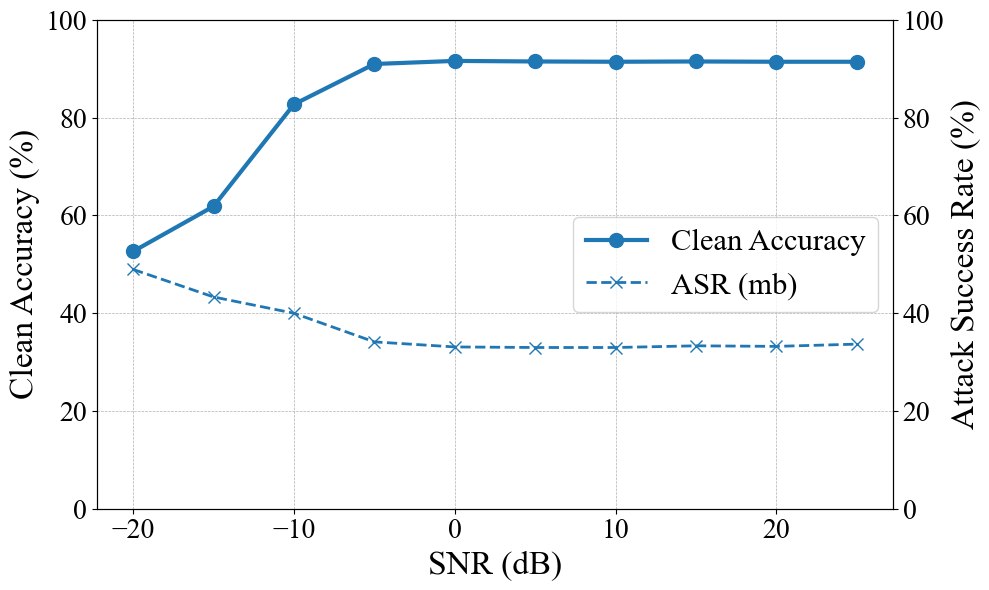

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


  SNR -15.0 dB → 4333.33%


<Figure size 640x480 with 0 Axes>

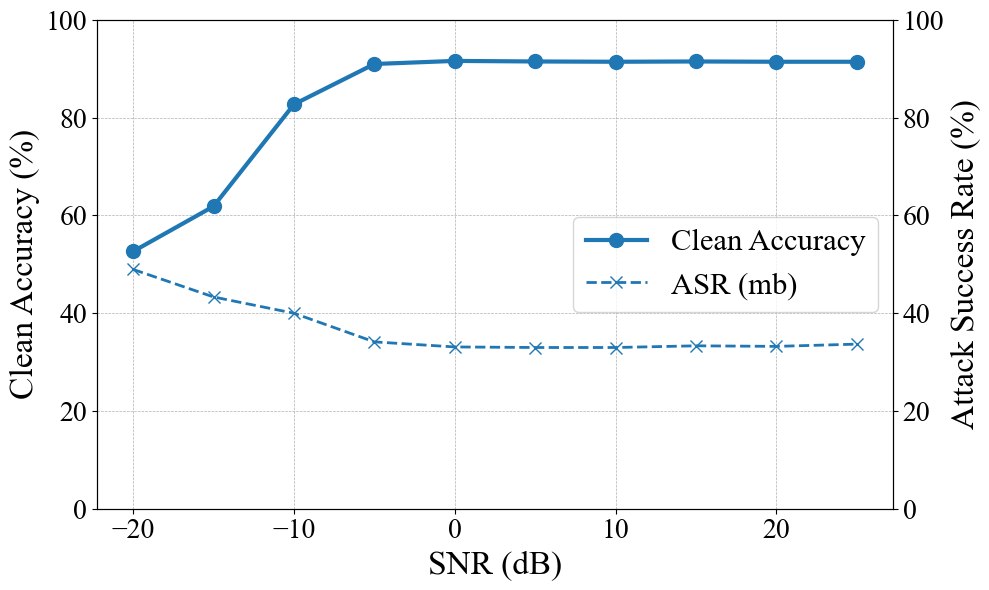

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


  SNR -10.0 dB → 4000.00%


<Figure size 640x480 with 0 Axes>

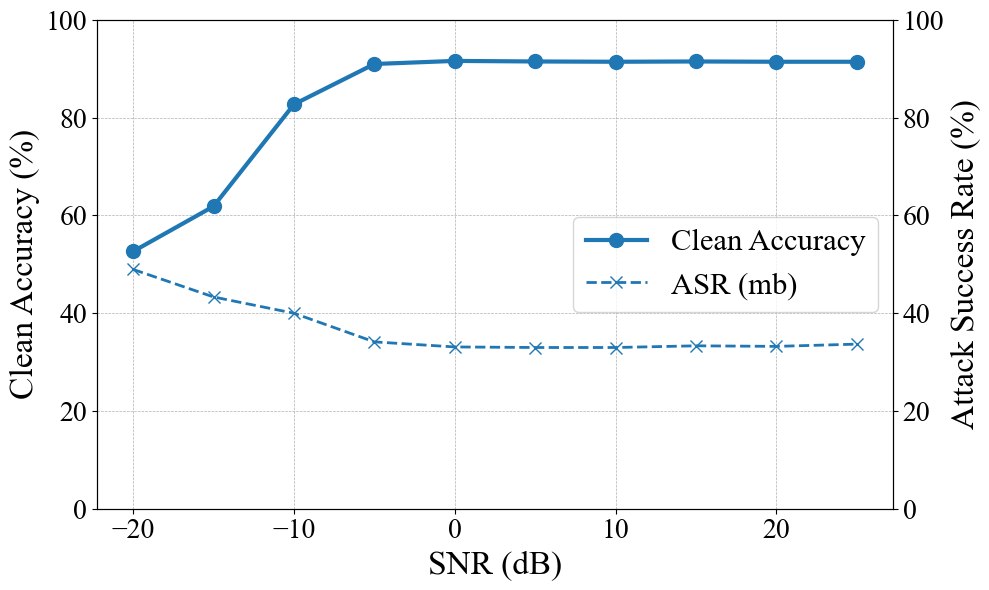

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


  SNR -5.0 dB → 3413.79%


<Figure size 640x480 with 0 Axes>

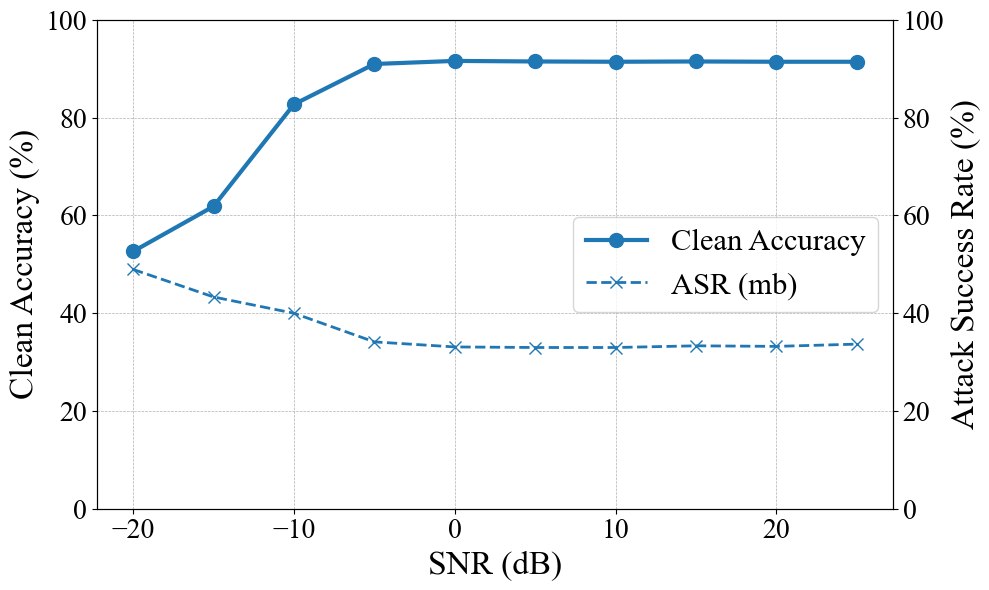

  SNR 0.0 dB → 3310.34%


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

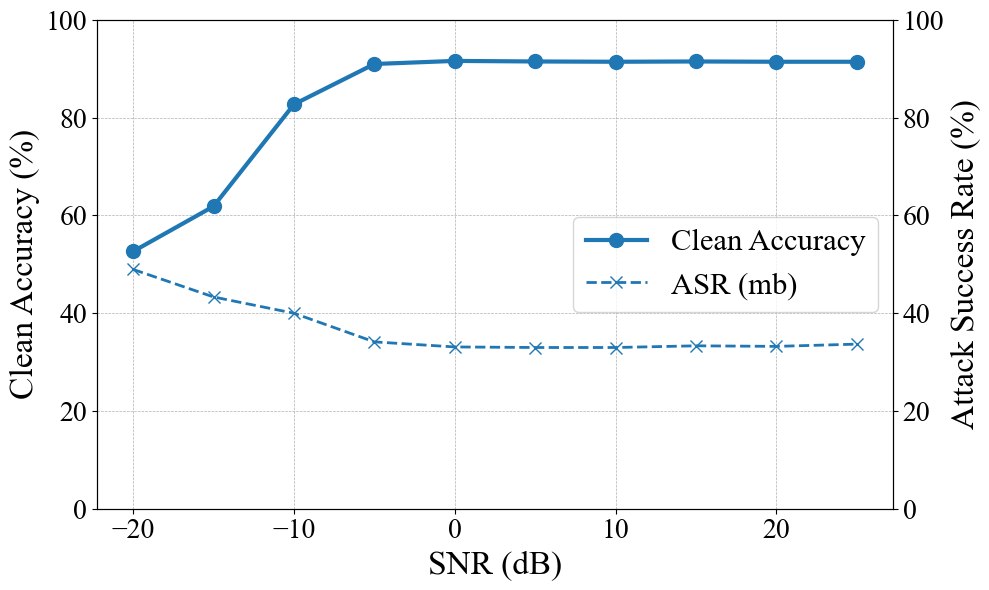

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


  SNR 5.0 dB → 3298.85%


<Figure size 640x480 with 0 Axes>

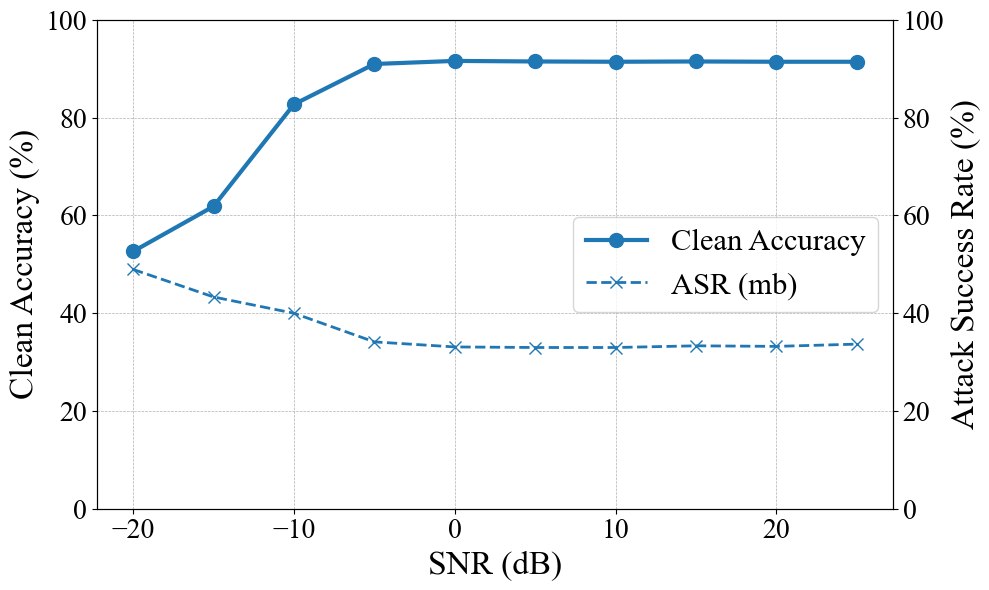

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


  SNR 10.0 dB → 3298.85%


<Figure size 640x480 with 0 Axes>

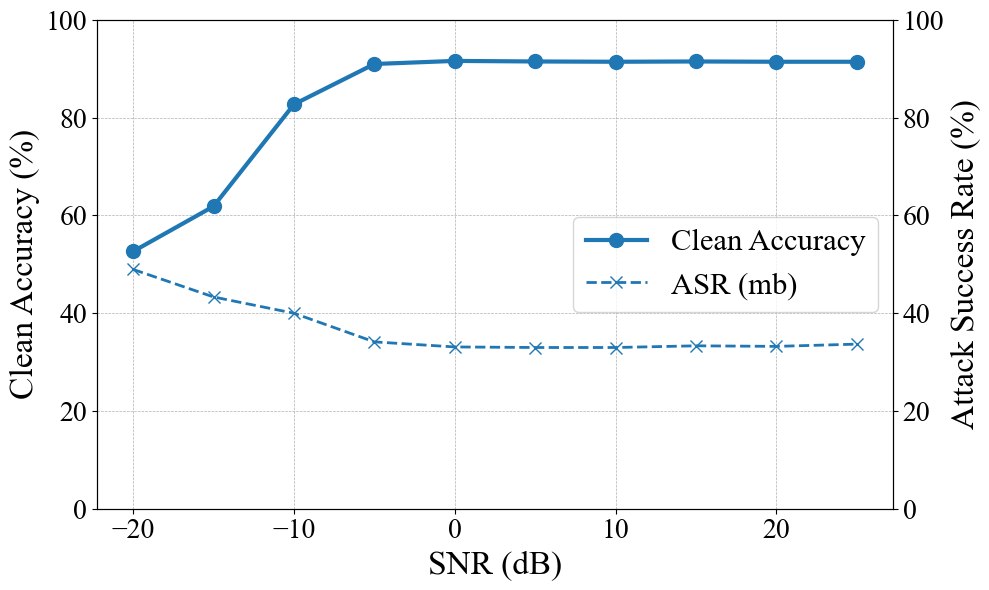

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


  SNR 15.0 dB → 3333.33%


<Figure size 640x480 with 0 Axes>

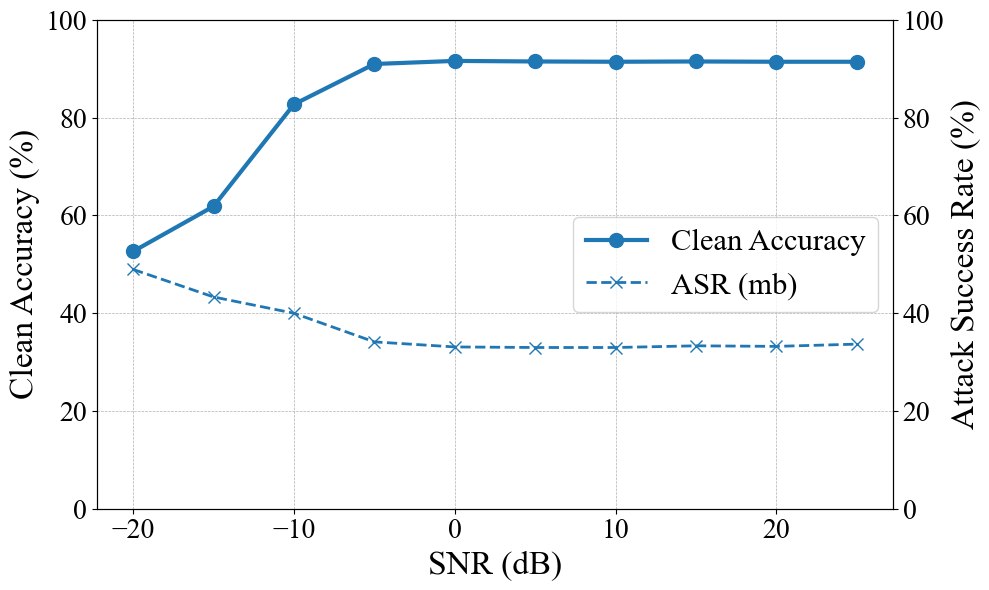

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


  SNR 20.0 dB → 3321.84%


<Figure size 640x480 with 0 Axes>

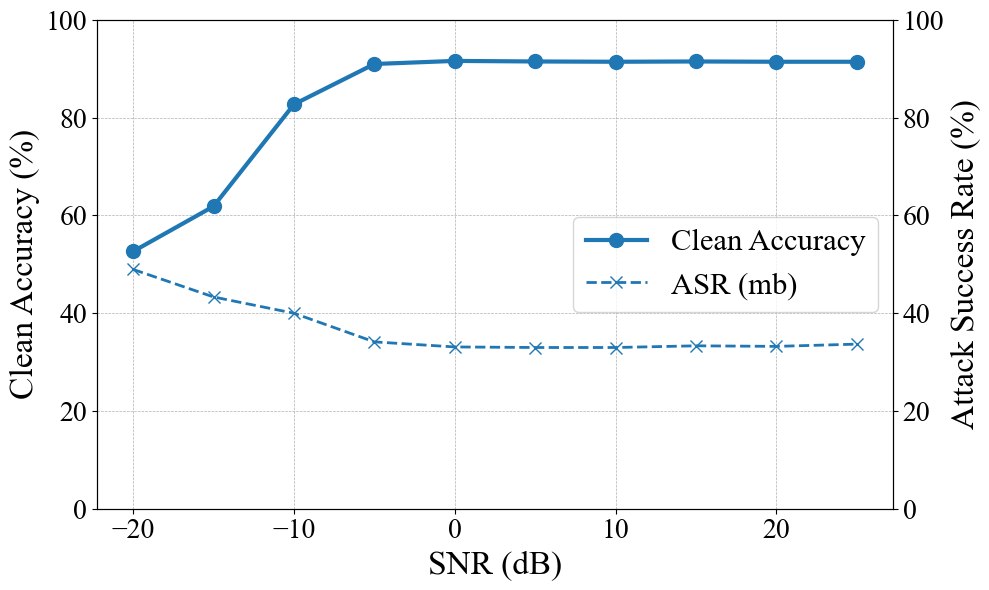

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


  SNR 25.0 dB → 3367.82%


<Figure size 640x480 with 0 Axes>

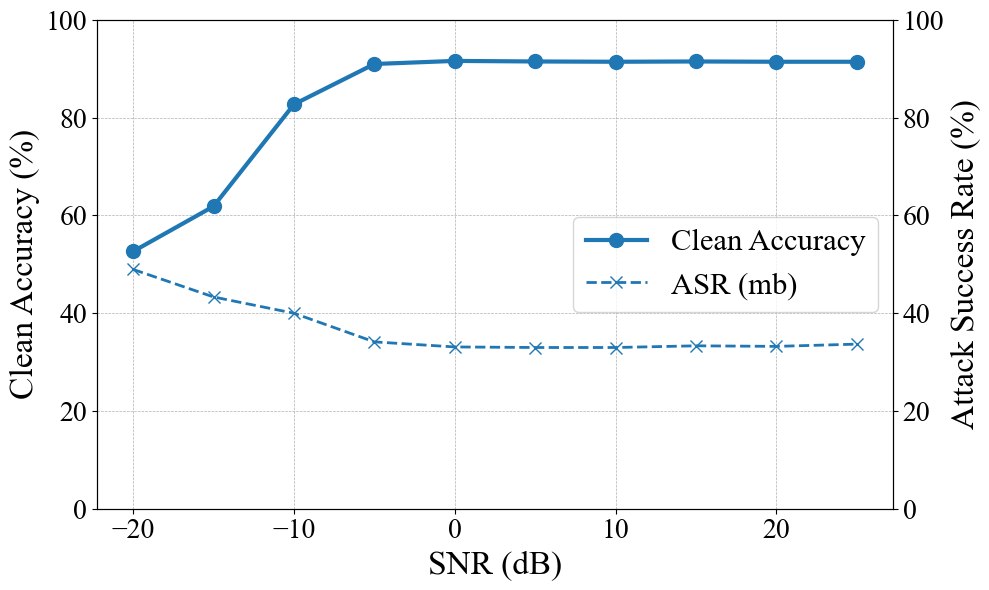

In [ ]:
ckpt_dir = "/home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_JSSC_new_sampling_ATK_MULTI_cummulative"
trigger_ckpts = {}
for tr in triggers:
    # look for any file matching checkpoint_full*_<tr>.pth
    pattern = os.path.join(ckpt_dir, f"checkpoint_full*_{tr}.pth")
    matches = glob.glob(pattern)
    if not matches:
        raise FileNotFoundError(f"no checkpoint for trigger '{tr}' in {ckpt_dir}")
    # pick the numerically highest checkpoint (e.g. full07 over full04)
    matches.sort(key=lambda p: int(os.path.basename(p).split("_full")[-1].split(f"_{tr}")[0]))
    trigger_ckpts[tr] = matches[-1]




if __name__ == '__main__':
    args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    deepsc = MODJSCC_WithHyperprior_real_bit(args.d_model, freeze_bert=False).to(args.device)

    model_paths = [os.path.join(args.checkpoint_path, fn) for fn in os.listdir(args.checkpoint_path) if fn.endswith('.pth')]
    model_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_full')[-1]))
    model_path = "/home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_AWGN_JSSC_new_model_2/checkpoint_full04.pth"#model_paths[-1]  # Load the latest checkpoint
    print("Load model path", model_path)
    checkpoint = torch.load(model_path, map_location=device)
    deepsc.load_state_dict(checkpoint, strict=True)

    clean_dataset = ds["validation"]
    clean_dataset = clean_dataset.map(preprocess_sst2, batched=True)
    clean_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    snr_dbs = np.linspace(-20, 25, num=10)
    nvars = [snr_db_to_nvar(snr) for snr in snr_dbs]

    triggers = ["cf", "tq", "mn", "bb", "mb"]
    n_runs = 2  # ← number of independent inference passes per SNR

    mean_clean_accs = []
    mean_asrs    = {tr: [] for tr in triggers}

    for n_var in nvars:
        acc_runs = []
        asr_runs = {tr: [] for tr in triggers}

        # clean-accuracy runs
        for _ in range(n_runs):
            acc_runs.append(evaluate_clean_accuracy(deepsc, clean_dataset, n_var=n_var))

        # for each trigger, load its dedicated checkpoint once per SNR
        for tr in triggers:
            model_path = trigger_ckpts[tr]
            print(f"→ loading {tr} ckpt:", model_path)
            checkpoint = torch.load(model_path, map_location=args.device)
            deepsc.load_state_dict(checkpoint, strict=True)

            # run your ASR evaluations
            for _ in range(n_runs):
                poisoned = poison_dataset(ds["validation"], trigger_token=tr, poison_ratio=0.1)
                # … preprocess test_set …
                asr = evaluate_attack_success_rate(
                    model=deepsc,
                    poisoned_dataset=test_set,
                    n_var=n_var
                )
                asr_runs[tr].append(asr)

        # average & store
        # mean_clean_accs.append(np.mean(acc_runs))
        # for tr in triggers:
        #     mean_asrs[tr].append(np.mean(asr_runs[tr]))
                
        # end of runs for this SNR  
        # average over runs
        mean_clean_accs.append(np.mean(acc_runs))
        for tr in triggers:
            mean_asrs[tr].append(np.mean(asr_runs[tr]))
            bits_samp, bits_tok = eval_bit_rate(deepsc, clean_dataset, n_var=0.1, device="cuda")
            vocab_bits = math.log2(30_000)   # ≈15

            print(f"Avg bits/sample: {bits_samp:.2f}")
            print(f"Avg bits/token : {bits_tok:.3f}")
            print(f"Compression ratio: {bits_tok/vocab_bits:.2%} of raw token bits")
    asr_matrix = np.vstack([mean_asrs[tr] for tr in triggers])  
# take mean over the 0th axis (i.e. over triggers)
    mean_asr_all = asr_matrix.mean(axis=0)  

    print("Average ASR across all triggers:")
for snr, avg_asr in zip(snr_dbs, mean_asr_all):
    print(f"  SNR {snr:.1f} dB → {avg_asr*100:.2f}%")
    # now plot the *mean* curves
    import matplotlib.font_manager as fm
    paths = [
    "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf",
    "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Bold.ttf",
    "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Italic.ttf",
    "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Bold_Italic.ttf",
    ]
    for p in paths:
        if os.path.exists(p):
            fm.fontManager.addfont(p)
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    plt.rcParams['axes.labelsize'] = 24
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20
    plt.rcParams['legend.fontsize'] = 22
    plt.rcParams['pdf.fonttype'] = 42  # Ensures editable text in PDFs
    plt.rcParams['ps.fonttype'] = 42
    plt.tight_layout()

    # === replace your single-axis plotting with this ===
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # plot clean accuracy on ax1
    ax1.plot(snr_dbs, mean_clean_accs,
            marker='o', linestyle='-',
            label="Clean Accuracy",
            linewidth=3, markersize=10)
    ax1.set_xlabel("SNR (dB)")
    ax1.set_ylabel("Clean Accuracy (%)")
    ax1.tick_params(axis='y')

    # create a second y-axis sharing the same x-axis
    ax2 = ax1.twinx()

    # plot each trigger’s ASR on ax2

    ax2.plot(snr_dbs, mean_asr_all,
                marker='x', linestyle='--',
                label=f"Avg ASR method 1)",
                linewidth=2, markersize=8)
    ax2.set_ylabel("Attack Success Rate (%)")
    ax2.tick_params(axis='y')
    ax2.set_ylim(0, 100)  # Ensure ASR is in [0, 100] range
    ax1.set_ylim(0, 100)  # Ensure clean accuracy is in [0, 100] range
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    # combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2,
            loc='center right', ncol=1)

    fig.tight_layout()
    fig.savefig("def1.eps",
                format='eps', bbox_inches='tight')
    plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


  SNR -20.0 dB → 4896.55%


<Figure size 640x480 with 0 Axes>

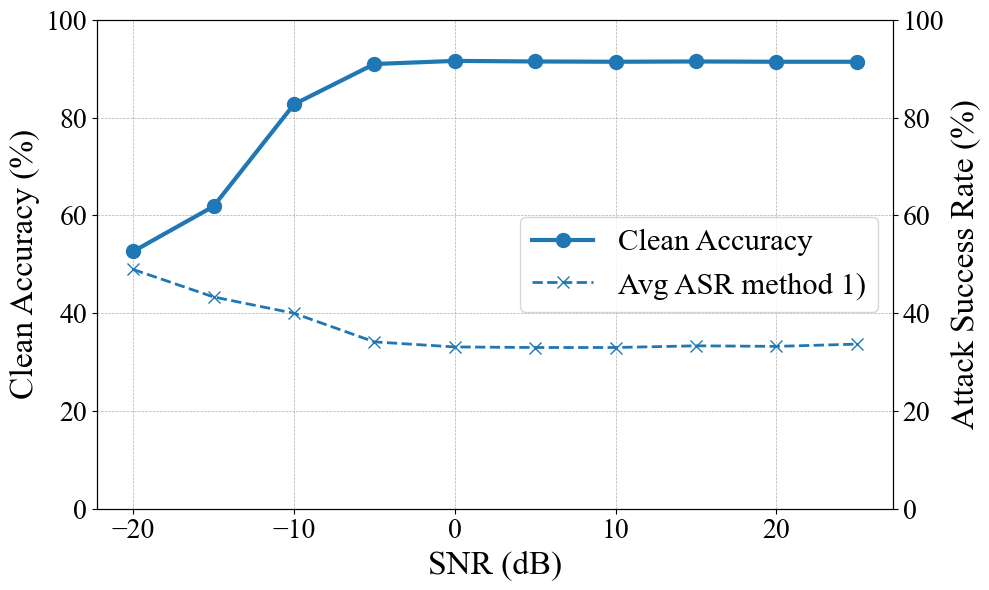

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


  SNR -15.0 dB → 4333.33%


<Figure size 640x480 with 0 Axes>

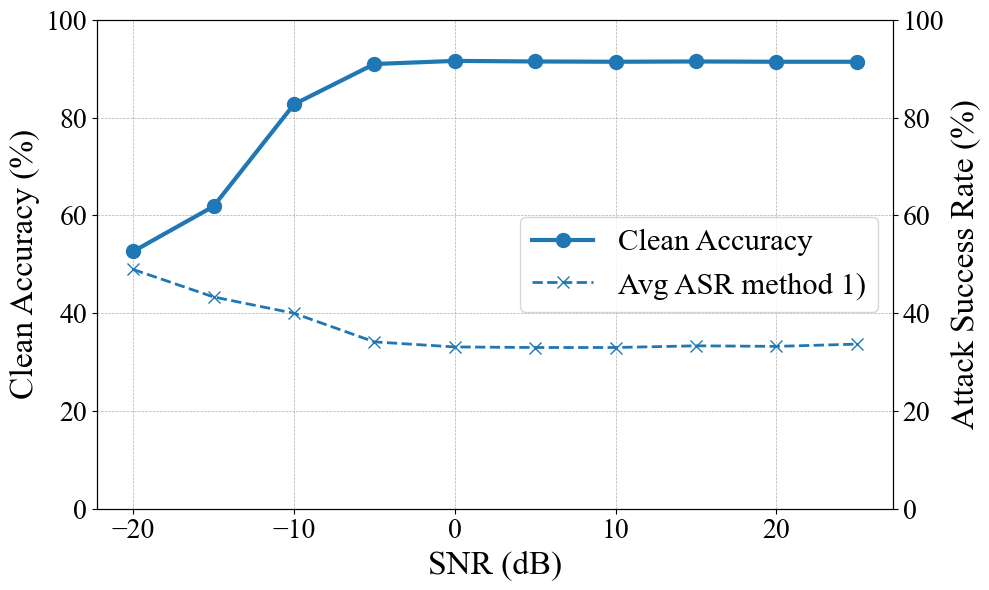

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


  SNR -10.0 dB → 4000.00%


<Figure size 640x480 with 0 Axes>

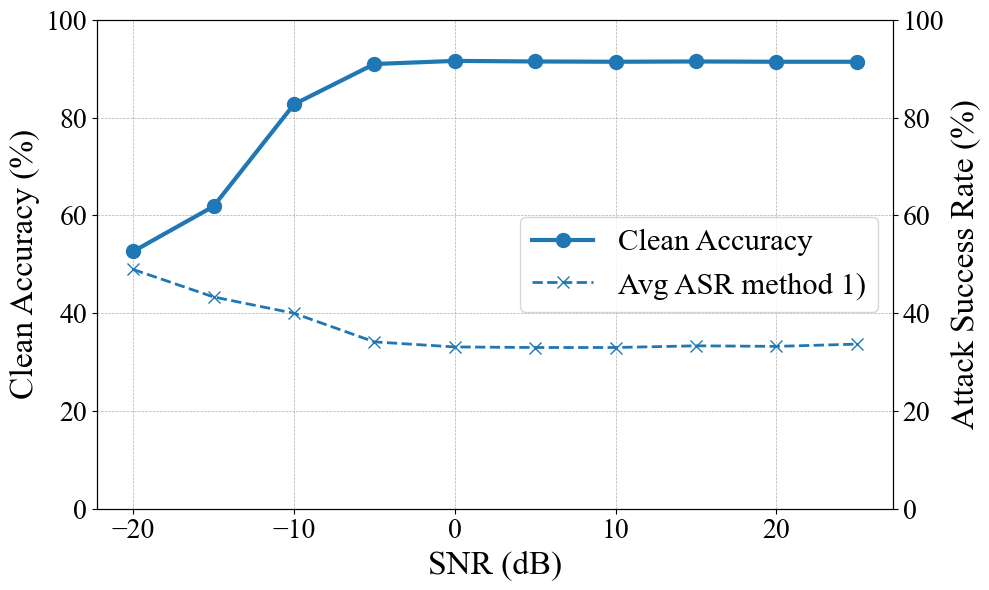

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


  SNR -5.0 dB → 3413.79%


<Figure size 640x480 with 0 Axes>

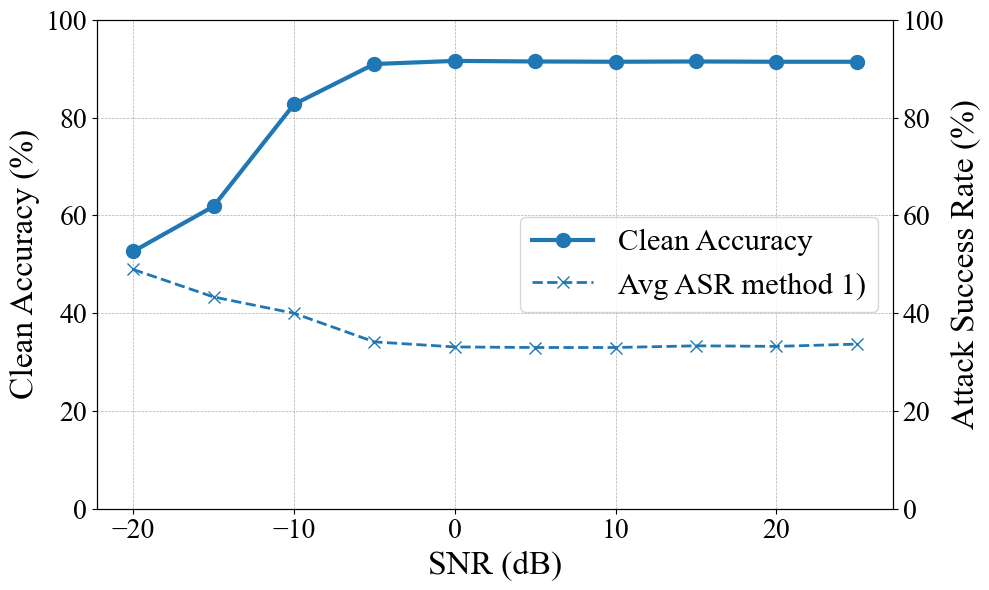

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


  SNR 0.0 dB → 3310.34%


<Figure size 640x480 with 0 Axes>

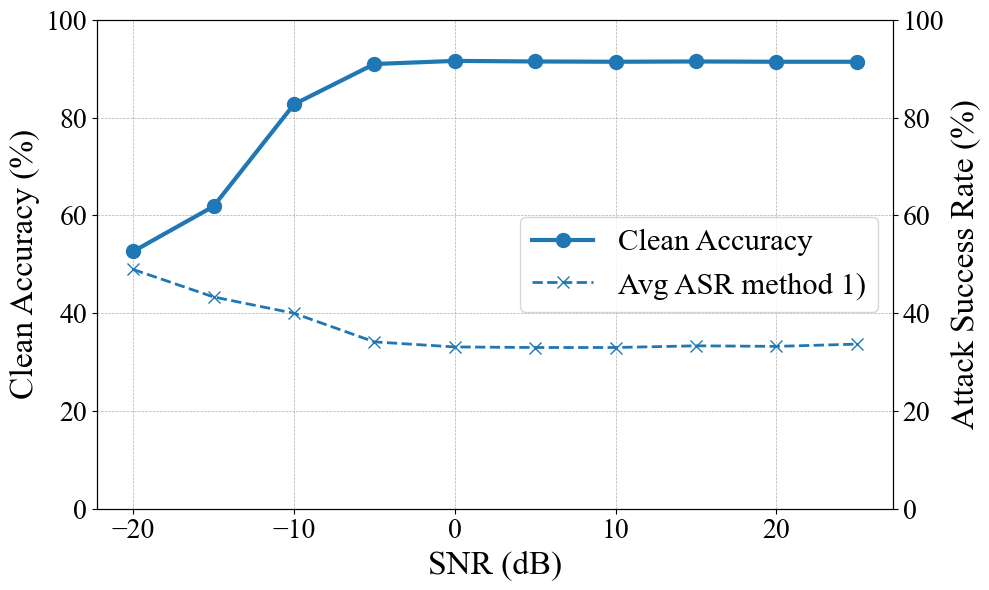

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


  SNR 5.0 dB → 3298.85%


<Figure size 640x480 with 0 Axes>

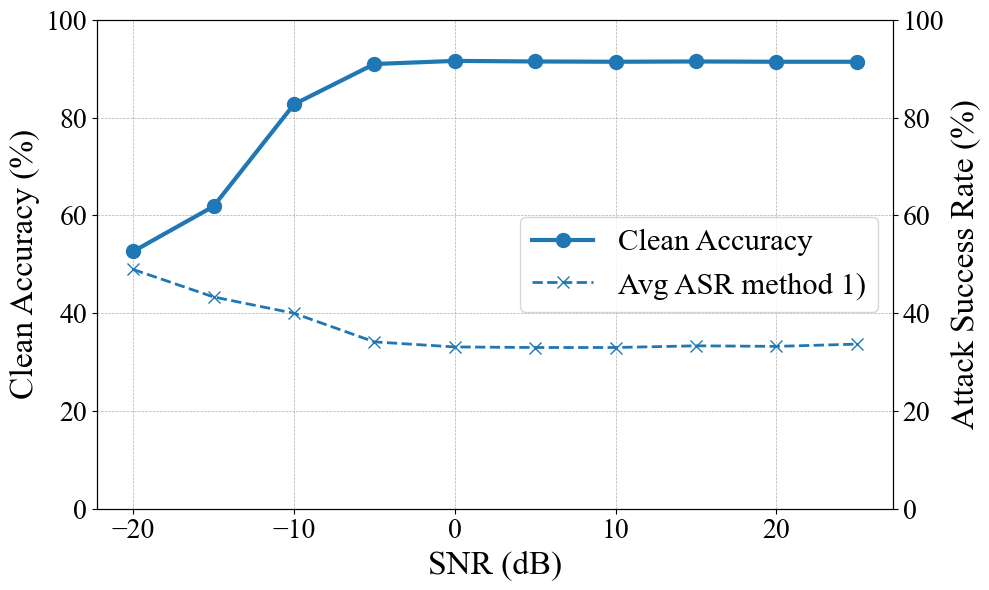

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


  SNR 10.0 dB → 3298.85%


<Figure size 640x480 with 0 Axes>

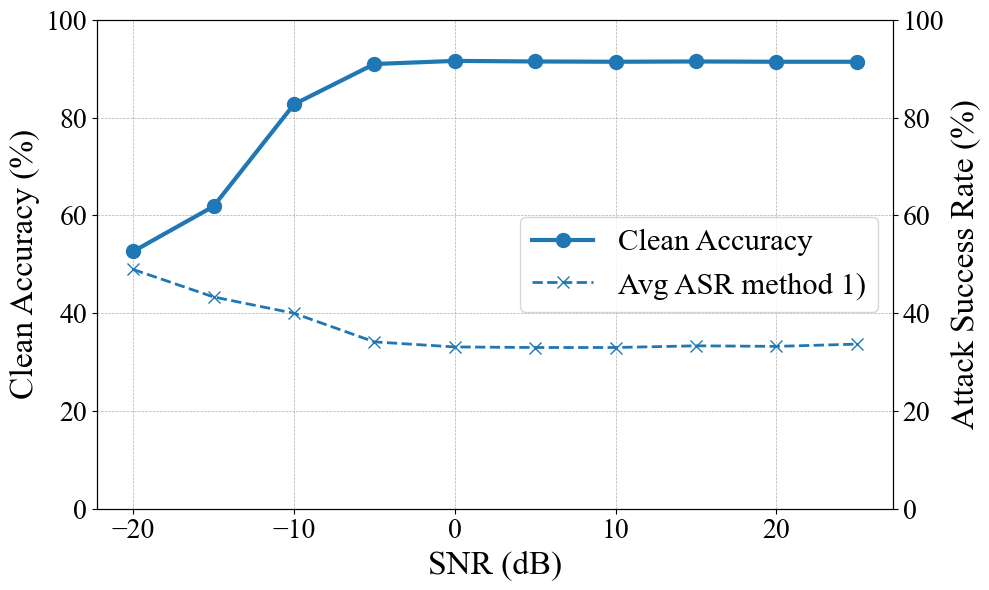

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


  SNR 15.0 dB → 3333.33%


<Figure size 640x480 with 0 Axes>

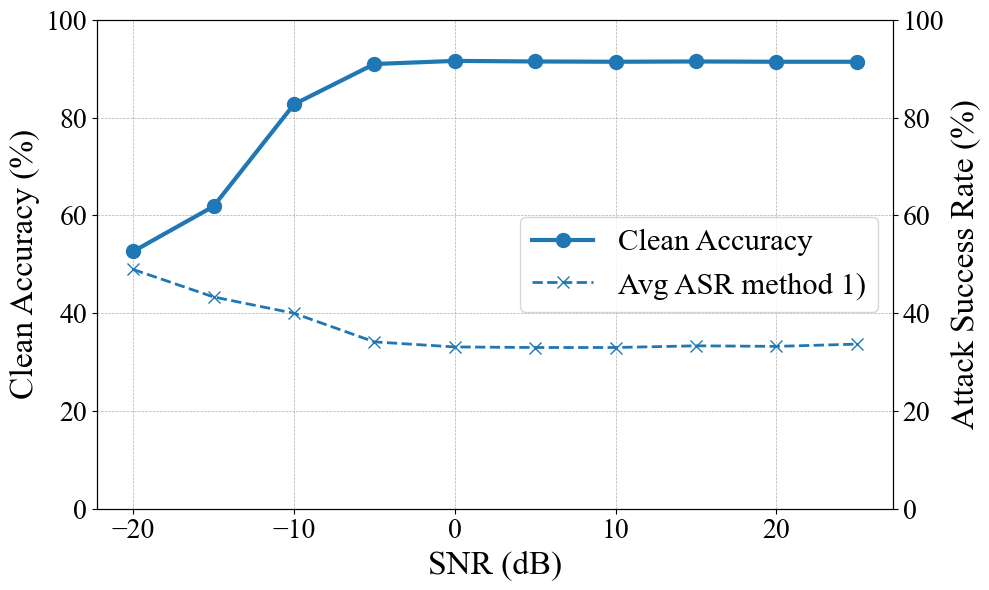

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


  SNR 20.0 dB → 3321.84%


<Figure size 640x480 with 0 Axes>

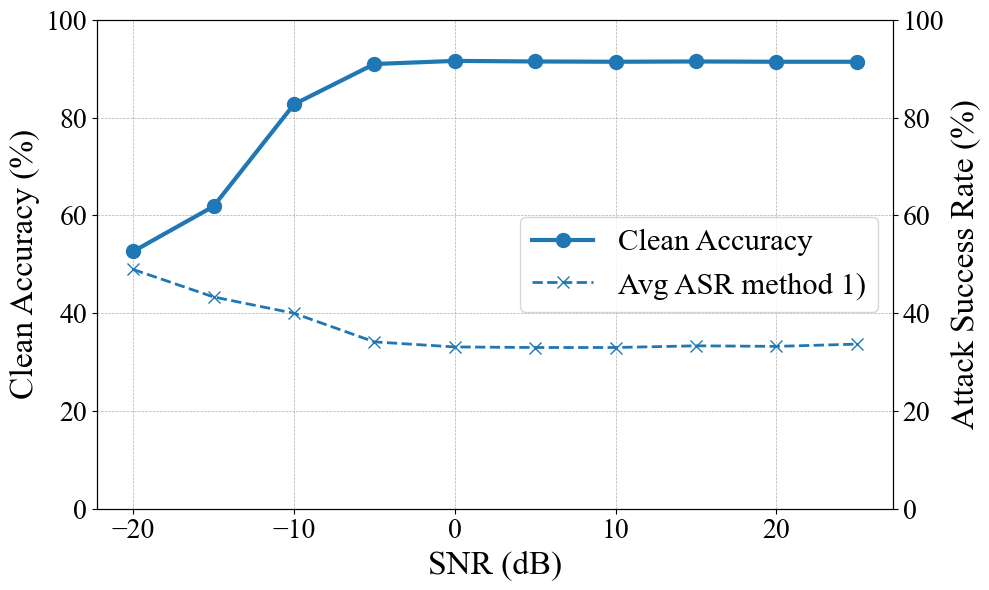

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


  SNR 25.0 dB → 3367.82%


<Figure size 640x480 with 0 Axes>

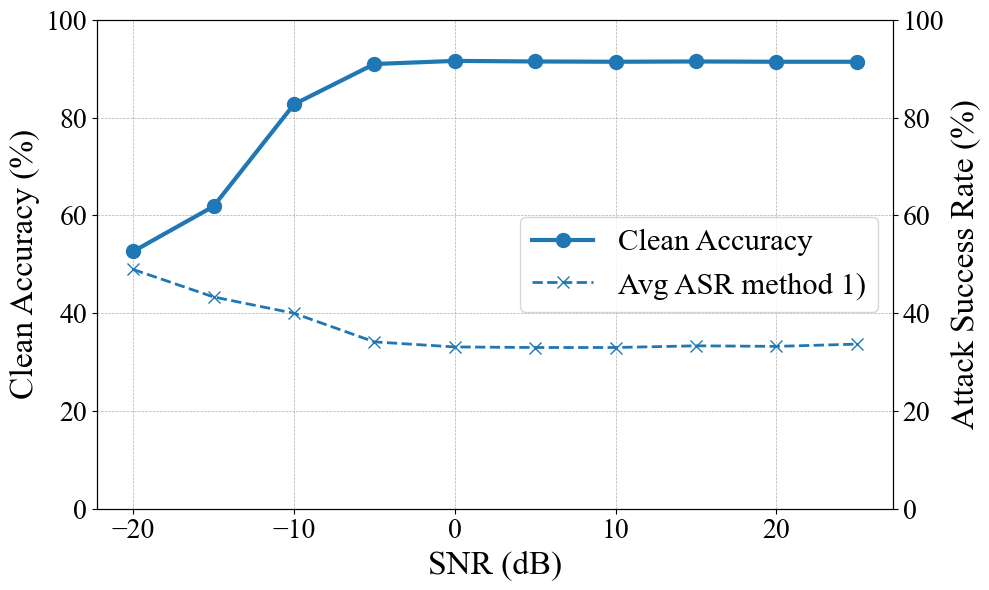

In [ ]:
for snr, avg_asr in zip(snr_dbs, mean_asr_all):
    print(f"  SNR {snr:.1f} dB → {avg_asr*100:.2f}%")
    # now plot the *mean* curves
    import matplotlib.font_manager as fm
    paths = [
    "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf",
    "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Bold.ttf",
    "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Italic.ttf",
    "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Bold_Italic.ttf",
    ]
    for p in paths:
        if os.path.exists(p):
            fm.fontManager.addfont(p)
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    plt.rcParams['axes.labelsize'] = 24
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20
    plt.rcParams['legend.fontsize'] = 22
    plt.rcParams['pdf.fonttype'] = 42  # Ensures editable text in PDFs
    plt.rcParams['ps.fonttype'] = 42
    plt.tight_layout()

    # === replace your single-axis plotting with this ===
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # plot clean accuracy on ax1
    ax1.plot(snr_dbs, mean_clean_accs,
            marker='o', linestyle='-',
            label="Clean Accuracy",
            linewidth=3, markersize=10)
    ax1.set_xlabel("SNR (dB)")
    ax1.set_ylabel("Clean Accuracy (%)")
    ax1.tick_params(axis='y')

    # create a second y-axis sharing the same x-axis
    ax2 = ax1.twinx()

    # plot each trigger’s ASR on ax2

    ax2.plot(snr_dbs, mean_asr_all,
                marker='x', linestyle='--',
                label=f"Avg ASR method 1",
                linewidth=2, markersize=8)
    ax2.set_ylabel("Attack Success Rate (%)")
    ax2.tick_params(axis='y')
    ax2.set_ylim(0, 100)  # Ensure ASR is in [0, 100] range
    ax1.set_ylim(0, 100)  # Ensure clean accuracy is in [0, 100] range
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    # combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2,
            loc='center right', ncol=1)

    fig.tight_layout()
    fig.savefig("def1.eps",
                format='eps', bbox_inches='tight')
    plt.show()
